In [1]:
#imports
from __future__ import division
import time
import datetime
import copy
from itertools import product
import operator
from collections import OrderedDict

import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score

import altair as alt
alt.renderers.enable("notebook")
import ipywidgets as wid
from IPython.display import display

In [81]:
class ForestForTheTrees:
    
    DEFAULT_LEARNING_RATE = 1.
    
    def __init__(self):
        
        self.dataset = None
        self.x = None
        self.y = None
        self.feature_names = None
        self.feature_locs = None
        self.feature_ranges = {}
        self.target_type = None
        self.classifier_type = None
        self.classifier = None
        self.mean_prediction = None
        self.no_predictor_features = []
        self.oned_features = []   
        self.binned_data = None
        self.sample_size = None
        self.num_tiles = None
        self.quantiles = None
        self.learning_rate = self.DEFAULT_LEARNING_RATE
        self.predictions_base = None
        self.chart_components = {}
        self.explanation_components = {}
        self.base_explanation = []
        self.evaluation_details = []
        self.base_components = []
        self.explanation = []
        self.cache = {}
        
    def __init__(self, dataset, sample_size, num_tiles, quantiles, learning_rate):
        
        self.classifier_type = None
        self.classifier = None
        self.mean_prediction = None
        self.no_predictor_features = []
        self.oned_features = []   
        self.binned_data = None
        self.sample_size = sample_size #may be set to none here, will be handled in load_dataset()
        self.num_tiles = num_tiles
        self.quantiles = quantiles
        self.learning_rate = learning_rate
        self.predictions_base = None
        self.chart_components = {}
        self.explanation_components = {}
        self.base_explanation = []
        self.evaluation_details = []
        self.base_components = []
        self.explanation = []
        self.cache = {}
        self.load_dataset(dataset)
        
    def set_sample_size(self, new_size):
        self.sample_size = new_size
    
    def get_dataset(self, dataset):
        
        if dataset == "bike":
            def _datestr_to_timestamp(s):
                return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d").timetuple())

            dataLoad = pd.read_csv('data/bike.csv')
            dataLoad['dteday'] = dataLoad['dteday'].apply(_datestr_to_timestamp)
            dataLoad = pd.get_dummies(dataLoad, prefix=["weathersit"], columns=["weathersit"], drop_first = False)

            #de-normalize data to produce human-readable features.
            #Original range info from http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset
            dataLoad["hum"] = dataLoad["hum"].apply(lambda x: x*100.)
            dataLoad["windspeed"] = dataLoad["windspeed"].apply(lambda x: x*67.)
            #convert Celsius to Fahrenheit
            dataLoad["temp"] = dataLoad["temp"].apply(lambda x: (x*47. - 8)*9/5 +32)
            dataLoad["atemp"] = dataLoad["atemp"].apply(lambda x: (x*66. - 16)*9/5 + 32)

            #rename features to make them interpretable for novice users
            feature_names_dict = {
                "yr":"First or Second Year", 
                "season":"Season", 
                "hr":"Hour of Day", 
                "workingday":"Work Day",
                "weathersit_2":"Misty Weather",
                "weathersit_3":"Light Precipitation",
                "weathersit_4":"Heavy Precipitation",
                "temp":"Temperature (F)",
                "atemp":"Feels Like (F)",
                "hum":"Humidity",
                "windspeed":"Wind Speed"
            }
            dataLoad = dataLoad.rename(mapper=feature_names_dict,axis=1) 
            features = feature_names_dict.values()

            return {
                "x": dataLoad[features].values,
                "y": dataLoad["cnt"],
                "feature_names": features,
                "feature_locs": {x:i for i,x in enumerate(features)},
                "target_type": "regression"
            }

    def bin_data(self):
    
        prediction_contributions = {}
        sample_data = pd.DataFrame(
            self.get_sample(self.x),
            columns = self.feature_names
        )
        for key in self.get_feature_pairs():
            tempH = np.digitize(
                sample_data.loc[:,key[0]],
                self.feature_ranges[key[0]]
            )-1.
            tempV = np.digitize(
                sample_data.loc[:,key[1]],
                self.feature_ranges[key[1]]
            )-1.
            prediction_contributions[key] = (tempV*len(self.feature_ranges[key[0]]) + tempH).astype(int)
        return prediction_contributions        
        
    def load_dataset(self, dataset):

        self.dataset = dataset
        data = self.get_dataset(self.dataset)
        self.x = data["x"]
        self.y = data["y"]
        self.feature_names = data["feature_names"]
        self.feature_locs = data["feature_locs"]
        self.target_type = data["target_type"]
        self.feature_ranges = {
            feature : self.get_quantiles(feature)
            for feature in self.feature_names
        } 
        if self.sample_size is None:
            self.sample_size = self.x.shape[0]
        self.binned_data = self.bin_data()    
            
    def build_base_model(self, num_estimators):

        self.model_type = "regression"
        self.classifier_type = GradientBoostingRegressor

        self.model = self.classifier_type(
            n_estimators=num_estimators, 
            max_depth=2, 
            learning_rate = self.learning_rate
        )
        self.model.fit(self.x, self.y)
        self.pred_y = self.model.predict(self.x)

    def get_model_accuracy(self):
        return r2_score(self.y, self.pred_y)    
        
    def _get_coordinate_matrix(self, lst, length, direction):
        if direction=="h":
            return lst*length
        else:
            return [item for item in lst\
             for i in range(length)]   

    def get_quantile_matrix(self, feat1, feat2):
        h = self._get_coordinate_matrix(
            list(self.feature_ranges[feat1]),
            len(self.feature_ranges[feat2]),
            "h"
        )
        v = self._get_coordinate_matrix(
            list(self.feature_ranges[feat2]),
            len(self.feature_ranges[feat1]),
            "v"
        )                      
        return h,v 

    def get_leaf_value(self, tree, node_position):
        node = tree.value[node_position]
        return node        

    def get_feature_pair_key(self, feat1, feat2):
        if self.feature_ranges[feat1].shape[0] == self.feature_ranges[feat2].shape[0]:
            #need stable order so keys with same number of quantiles appear in only one order
            return tuple(sorted([feat1, feat2]))
        elif self.feature_ranges[feat1].shape[0] > self.feature_ranges[feat2].shape[0]:
            return tuple([feat1, feat2])
        else:
            return tuple([feat2, feat1])        

    def get_quantiles(self, feat):
        loc = self.feature_locs[feat]
        if np.unique(self.x[:,loc]).shape[0] < 30 or type(self.x[0,loc]) is str: #is categorical/ordinal?
            return np.unique(self.x[:,loc])
        else:
            if self.quantiles:
                return np.around(
                    np.unique(
                        np.quantile(
                            a=self.x[:,loc],
                            q=np.linspace(0, 1, self.num_tiles)
                        )
                    ),
                    1)
            else:
                return np.around(
                    np.linspace(
                        np.min(self.x[:,loc]), 
                        np.max(self.x[:,loc]),
                        self.num_tiles
                    )
                    ,1)  
            
    def reduce_to_1d(self, arr, threshold, direction):
        if direction == "h":
            reduced_arr = arr - arr[:,0].reshape(-1,1)
        else:
            reduced_arr = arr - arr[0,:].reshape(1,-1)
        return (np.max(np.abs(reduced_arr))/np.max(np.abs(arr))) <= threshold               
        
    def get_sample(self, arr):
        return arr[:self.sample_size]
    
    def get_predictions_base(self):
        return np.full((self.sample_size,1), np.mean(self.y))
    
    def get_empty_sample(self, size = None):
        return np.full((self.sample_size if size is None else size,1), 0)
    
    def get_explanation_accuracy(self, explanation_predictions):
        return r2_score(self.get_sample(self.pred_y), explanation_predictions)
        
    def get_prediction_contributions(self, chart, data_positions):
        return np.take(chart, data_positions)
    
    def sum_arrays(self, temp_outputs, keyMain, keyAdd, arr_to_add):
        return temp_outputs[keyMain]["output"]\
    + temp_outputs[keyAdd][arr_to_add].reshape(
            temp_outputs[keyMain]["output"].shape[0]
            if(keyMain[1]==keyAdd[1] or keyMain[1]==keyAdd[0])
            else 1,-1
        )
    
    def _drop_alternate_outputs(self,component):
        return {"output": component["output"]}
    
    def _get_prediction_contributions_df(self, components, explanation):
        return np.hstack(
            tuple(
                [
                    self.get_prediction_contributions(
                        components[expKey]["output"],
                        self.binned_data[expKey]
                    ).reshape(-1, 1)\
                    for expKey in explanation                    
                ]
            )
        )
    
    def _get_prediction_contributions_by_key(self, components, explanation):
        return {
            expKey : 
            self.get_prediction_contributions(
                components[expKey]["output"],
                self.binned_data[expKey]
            ) for expKey in explanation
        }        

    def evaluate_single_explanation(self, components, explanation):
        
        return self.get_explanation_accuracy(
            self.predictions_base +\
            np.sum(
                np.array(
                    self._get_prediction_contributions_by_key(
                        components,
                        explanation
                    ).values()
                ), 
                axis = 0
            ).reshape(-1,1)
        )
    
    def _get_parallel_coordinate_columns(self, explanation, cumulative):
        #make these strings because Altair doesn't like a tuple as a key and turns it into a list
        return (["mean y"] if cumulative else [])\
    + [x[0] + "," + x[1] for x in explanation]\
    + (["prediction"] if cumulative else [])
    
    def _get_altair_data_type(self,feature_name, abbreviation = True):
        if self.feature_ranges[feature_name].shape[0] == self.num_tiles:
            return "Q" if abbreviation else "quantitative"
        else:
            return "O" if abbreviation else "ordinal"    
    
    def _get_datapoint_contributions(self, components, explanation):
        contributions = self._get_prediction_contributions_df(components, explanation)
        #raw contributions
        arr = np.hstack(
            (
                self.get_empty_sample().reshape(-1,1),
                contributions.reshape(self.sample_size, -1),
                self.get_sample(self.pred_y).reshape(-1,1),
                np.array([0. for x in range(self.sample_size)]).reshape(-1,1)
            )
        )
        
        #cumulative version
        arr_cum = np.cumsum(
            np.hstack(
                (
                    self.get_predictions_base().reshape(-1,1),
                    contributions.reshape(self.sample_size,-1)
                )
            ),
            axis = 1
        )
        
        arr_cum = np.hstack(
            (
                arr_cum,
                self.get_sample(self.pred_y).reshape(-1,1),
                np.array([1. for x in range(self.sample_size)]).reshape(-1,1)
            )
        )

        arr_df = pd.DataFrame(
            arr,
            columns = self._get_parallel_coordinate_columns(explanation, True) + ["view"]
        )
        
        #combine arrays
        arr_cum_df = pd.DataFrame(
            arr_cum,
            columns = self._get_parallel_coordinate_columns(explanation, True) + ["view"]
        )
        
        #generate datapoint id columns
        arr_df = arr_df.reset_index(drop = False)
        arr_cum_df = arr_cum_df.reset_index(drop = False)
        datapoints = pd.concat([arr_df, arr_cum_df])
        
        #couldn't do this earlier, as you can't vstack a mixed type array
        datapoints["view"] = datapoints["view"].apply(lambda x:\
                                                      'Predictions by Chart'\
                                                      if x < 1. else\
                                                      'Cumulative Predictions'\
                                                     )
        #calculate explanation loss
        datapoints["explanation_loss"] = np.abs( #otherwise the chart is hard to read with 0 in the middle of the axis
            datapoints.loc[:,"prediction"] - datapoints.iloc[:,-3]#last cumulative column
        )
        
        #datapoints = datapoints.reset_index(drop = False)
        datapoints["prediction_index"] = datapoints["prediction"]
        datapoints = datapoints.melt(
            id_vars = ['index', "prediction_index", "view", "explanation_loss"],
            var_name = 'component',
            value_name = 'contribution'
        )
        
        #rename prediction again
        datapoints = datapoints.rename({"prediction_index" : "prediction"}, axis = 1)

        #drop fake columns for "Predictions by Chart"
        datapoints = datapoints[
            (datapoints["view"] == "Cumulative Predictions")
            | (~datapoints["component"].isin(["prediction", "mean y", "explanation_loss"]))
        ]
        
        #build sort column for Altair
        datapoints["sort"] = datapoints["component"].apply(lambda x:
                                                           self._get_parallel_coordinate_columns(
                                                               explanation,
                                                               True
                                                           ).index(x)
                                                          )   
        return datapoints

    def copy_chart_components(self):
        return copy.deepcopy(self.chart_components)  
    
    def get_feature_pairs(self):
        return [
            self.get_feature_pair_key(key[0], key[1])
            for key in [tuple(t) for t in product(self.feature_names, repeat = 2)]
        ]       

    def rollup_components(self, explanation):
        temp_outputs = self.copy_chart_components()
        for keyRollup in [k for k in self.chart_components.iterkeys() if k not in explanation]:
            hUsed = False
            vUsed = False
            for keyExisting in explanation:
                if (keyRollup[1] == keyExisting[0] or keyRollup[1] == keyExisting[1]) and not hUsed:
                    hUsed = True
                    if vUsed:
                        temp_outputs[keyExisting]["output"] = self.sum_arrays(
                            temp_outputs,
                            keyExisting, 
                            keyRollup,
                            "output_HReduced"
                        )
                        break
                    else:
                        temp_outputs[keyExisting]["output"] = self.sum_arrays(
                            temp_outputs,
                            keyExisting, 
                            keyRollup,
                            "output_H"
                        )                           
                elif (keyRollup[0] == keyExisting[0] or keyRollup[0] == keyExisting[1]) and not vUsed:
                    vUsed = True
                    if hUsed:
                        temp_outputs[keyExisting]["output"] = self.sum_arrays(
                            temp_outputs,
                            keyExisting, 
                            keyRollup,
                            "output_VReduced"
                        )                          
                        break
                    else:
                        temp_outputs[keyExisting]["output"] = self.sum_arrays(
                            temp_outputs,
                            keyExisting, 
                            keyRollup,
                            "output_V"
                        )  
        return temp_outputs   
    
    def visualize_single_estimator(self, estimator_num):
        
        chart_components,\
        chart_indices,\
        _,\
        _,\
        function_texts = self._extract_components(False, [self.model.estimators_[estimator_num]], True)
        
        if len(function_texts) == 1:
            for x in [x for x in function_texts.values()[0]["function_texts"]]:
                print x
        else:
            for x in [x["function_texts"] for x in function_texts.values()]:
                for text in x:
                    print x[0]
        chart = self._visualize_components(
            chart_components.keys(),
            chart_components,
            None,
            chart_indices,
            False, 
            300
        )
        display(chart)
        return chart
    
    def _get_function_text(self, decision_func_dict):
        
        def _get_left_right_text(op, le, gt):
            if op == operator.le:
                return " is less than or equal to ", str(round(le,1)), str(round(gt,1))
            else:
                return " is greater than ", str(gt), str(le)
                
        
        if "feature_name" in decision_func_dict: #1-deep
            
            comparison_text, left, right = _get_left_right_text(
                decision_func_dict["operator"],
                decision_func_dict["prob_le"],
                decision_func_dict["prob_gt"]
            )
            
            text = "If " + decision_func_dict["feature_name"] + comparison_text\
            + str(round(decision_func_dict["threshold"],1)) + " then " + left\
            + " else " + right + ". "
            
            return text
        
        else: #2-deep
            comparison_text_1, left_1, right_1 = _get_left_right_text(
                decision_func_dict["operator_1"],
                0,
                0
            )

            comparison_text_2, left_2, right_2 = _get_left_right_text(
                decision_func_dict["operator_2"],
                decision_func_dict["prob_le"],
                decision_func_dict["prob_gt"]
            ) 
            
            
            text = "If " + decision_func_dict["feature_name_1"] + comparison_text_1\
            + str(round(decision_func_dict["threshold_1"],1)) + " then proceed. If "\
            + decision_func_dict["feature_name_2"] + comparison_text_2\
            + str(round(decision_func_dict["threshold_2"],1)) + " then " + left_2 + " else " + right_2 + ". "
            
            return text
    
    def extract_components(self, collapse_1d = True, return_text = False):
        
        self.chart_components,\
        self.chart_indices,\
        self.no_predictor_features,\
        self.oned_features,\
        self.estimator_texts = self._extract_components(collapse_1d, self.model.estimators_, return_text)
        
        self.predictions_base = self.get_predictions_base()
        
        #get the full explanation and store it. one reason for this is so that
        #charts can also be sorted appropriately
        #don't save explanation components as they will be the same as chart_components
        self.base_explanation, _, _\
        = self._explain(1., None)        
        
    def _extract_components(self, collapse_1d, estimators, return_text):

        #generate data structure for pairwise charts
        feature_pairs = {
            key : {
                "map":None,
                "predicates":[],
                "function_texts":[]
            }
            for key in self.get_feature_pairs()
        }      

        for key, value in feature_pairs.iteritems():
            h, v = self.get_quantile_matrix(key[0], key[1])
            value["map"] = np.array(
                [
                    {
                        key[0] : x,
                        key[1] : y
                    }
                    for x,y in zip(h,v)
                ]
            ).reshape(len(self.feature_ranges[key[1]]), len(self.feature_ranges[key[0]]))

        for modelT in estimators:
            curr_model = modelT[0]
            feature_ids = {
                i : {
                    "number":x,
                    "name":self.feature_names[x]
                } for i,x in enumerate(list(curr_model.tree_.feature))
                if x >= 0
            } #-2 means leaf node

            #for 1-layer trees
            if curr_model.tree_.feature[1] < 0:
                feature_pair_key = self.get_feature_pair_key(
                    feature_ids[0]["name"],
                    feature_ids[0]["name"]
                )
                decision_func_dict = {
                    "feature_name": feature_ids[0]["name"],
                    "threshold": curr_model.tree_.threshold[0],
                    "operator": operator.le,
                    "prob_le": self.get_leaf_value(curr_model.tree_, 1),
                    "prob_gt": self.get_leaf_value(curr_model.tree_, 2)
                }       
                #build the predictive function used in the decision tree
                def dt_predicate(data_case, decision_func_dict=decision_func_dict):
                    if decision_func_dict["operator"](\
                                                        data_case[decision_func_dict["feature_name"]],\
                                                        decision_func_dict["threshold"]\
                                                       ):
                        return decision_func_dict["prob_le"]
                    else:
                        return decision_func_dict["prob_gt"]        
            else:
                for node_position in [1,4]: #positions for left and right nodes at layer 2
                    if node_position in feature_ids:
                        feature_pair_key = self.get_feature_pair_key(
                            feature_ids[0]["name"], 
                            feature_ids[node_position]["name"]
                        )
                        #get the decision rules
                        decision_func_dict = {
                            "feature_name_1": feature_ids[0]["name"],
                            "threshold_1": curr_model.tree_.threshold[0],
                            "operator_1": operator.le if node_position == 1 else operator.gt,

                            "feature_name_2": feature_ids[node_position]["name"],
                            "threshold_2": curr_model.tree_.threshold[node_position],
                            "operator_2": operator.le,

                            "prob_le": self.get_leaf_value(curr_model.tree_, node_position+1),
                            "prob_gt": self.get_leaf_value(curr_model.tree_, node_position+2)
                        }
                        #build the predictive function used in the decision tree
                        def dt_predicate(data_case, decision_func_dict=decision_func_dict):
                            if decision_func_dict["operator_1"](\
                                                                data_case[decision_func_dict["feature_name_1"]],\
                                                                decision_func_dict["threshold_1"]\
                                                               ):
                                if decision_func_dict["operator_2"](\
                                                                    data_case[decision_func_dict["feature_name_2"]],\
                                                                    decision_func_dict["threshold_2"]\
                                                                   ):
                                    return decision_func_dict["prob_le"]
                                else:
                                    return decision_func_dict["prob_gt"]
                            else:
                                return 0.

                    else: #asymmetric tree, this is a leaf node
                        feature_pair_key = self.get_feature_pair_key(
                            feature_ids[0]["name"], 
                            feature_ids[0]["name"]
                        )
                        decision_func_dict = {
                            "feature_name": feature_ids[0]["name"],
                            "threshold": curr_model.tree_.threshold[0],
                            "operator": operator.le if node_position == 1 else operator.gt,
                            "prob": curr_model.tree_.value[node_position]
                        }
                        #build the predictive function used in the decision tree
                        def dt_predicate(data_case, decision_func_dict=decision_func_dict):
                            if decision_func_dict["operator"](\
                                                                data_case[decision_func_dict["feature_name"]],\
                                                                decision_func_dict["threshold"]\
                                                               ):
                                return decision_func_dict["prob"]
                            else:                         
                                return 0.                 

                    feature_pairs[feature_pair_key]["predicates"].append(dt_predicate)
                    if return_text:
                        feature_pairs[feature_pair_key]["function_texts"].append(
                            self._get_function_text(
                                decision_func_dict
                            )
                        )

        #now calculate output array for each feature pair
        for key, value in feature_pairs.iteritems():
            arrs = []
            for predicate in value["predicates"]:
                f = np.vectorize(predicate)
                arrs.append(f(value["map"]))
            if len(arrs) > 0:
                #details of vote aggreggation method for random forest
                #https://stats.stackexchange.com/questions/127077/random-forest-probabilistic-prediction-vs-majority-vote
                value["output"] = np.sum(np.stack(arrs, axis=-1), axis=-1)*self.learning_rate 
            else:
                value["output"] = None

        #build chart data
        for key, value in feature_pairs.iteritems():
            h,v = self.get_quantile_matrix(key[0], key[1])
            value["h_indices"] = h
            value["v_indices"] = v    

        no_predictor_features = []
        oned_features = []
        chart_data = {}
        for key, value in feature_pairs.iteritems(): 
            newKey = key
            if value["output"] is None:
                no_predictor_features.append(key)
                value["removed"] = True
            else:          
                if collapse_1d:
                    if self.reduce_to_1d(value["output"], 0., "v"):
                        newKey = key[1]
                        value["output"] = value["output"][0,:]
                        value["h_indices"] = self.feature_ranges[newKey]
                        value["v_indices"] = None
                        value["1d_key"] = newKey
                        value["removed"] = True
                        oned_features.append(key)                 
                    elif self.reduce_to_1d(value["output"], 0., "h"):
                        newKey = key[0]
                        value["output"] = value["output"][:,0]
                        value["h_indices"] = self.feature_ranges[newKey]
                        value["v_indices"] = None
                        value["1d_key"] = newKey
                        value["removed"] = True
                        oned_features.append(key)

        #do another loop through chart_data to push 1d charts into 2d
        if collapse_1d:
            for value in feature_pairs.itervalues():
                if value["v_indices"] is None:
                    key = value["1d_key"]
                    #get list of charts with this feature
                    matchList = sorted([{"key": kInner, "feature_importance": np.std(vInner["output"])}\
                                        for kInner, vInner in feature_pairs.iteritems()\
                                        if "removed" not in vInner and key in kInner],\
                                       key=lambda x: x["feature_importance"], reverse=True)

                    if len(matchList) > 0:
                        matchKey = matchList[0]["key"]
                        feature_pairs[matchKey]["output"] = feature_pairs[matchKey]["output"]\
                        + value["output"].reshape(\
                                                  -1 if key == matchKey[1] else 1,\
                                                  -1 if key == matchKey[0] else 1\
                                                 )

        #one last loop to generate the horizontal and vertical components
        for key, value in feature_pairs.iteritems():
            if "removed" in value:
                pass
            else:
                value["output_H"] = np.mean(value["output"], axis=1).reshape(-1,1)
                value["output_V"] = np.mean(value["output"], axis=0).reshape(1,-1)
                value["output_HReduced"] = np.mean(value["output"] - value["output_V"].reshape(1,-1), axis=1)\
                .reshape(1,-1)
                value["output_VReduced"] = np.mean(value["output"] - value["output_H"].reshape(-1,1), axis=0)\
                .reshape(-1,1)

        #remove deleted keys
        feature_pairs = {key:val for key, val in feature_pairs.iteritems() if "removed" not in val}
        feature_pairs = OrderedDict(sorted(feature_pairs.items(),\
                                            key=lambda x: np.std(x[1]["output"]), reverse=True))
        chart_components = {
            key: {
                "output" : val["output"],
                "output_VReduced" : val["output_VReduced"],
                "output_H" : val["output_H"],
                "output_HReduced" : val["output_HReduced"],
                "output_V" : val["output_V"]
            } for key, val in feature_pairs.iteritems()
        }

        chart_indices = {
            key: {
                "h_indices" : val["h_indices"],
                "v_indices" : val["v_indices"]
            } for key, val in feature_pairs.iteritems()
        }
        
        function_texts = {
            key : {
                "function_texts" : val["function_texts"]
            } for key, val in feature_pairs.iteritems()
        } if return_text else None
        
        return chart_components, chart_indices, no_predictor_features, oned_features, function_texts
        
    def _explain(self, fidelity_threshold = 1., rollup = None):

        explanation = []   
        explanation_components = {}
        evaluation_details = [
            {
                "score": self.get_explanation_accuracy(
                    self.predictions_base
                )
            }
        ]
        
        while evaluation_details[-1]["score"] < fidelity_threshold\
        and len(explanation) < len(self.chart_components):
            current_details = {}
            temp_outputs = {}
            keys_to_evaluate = [key for key in self.chart_components.iterkeys() if key not in explanation]
            for key in keys_to_evaluate:
                #roll up other keys
                current_explanation = explanation+[key]
                temp_outputs[key] = self.rollup_components(current_explanation)\
                if rollup == "advanced"\
                else self.copy_chart_components()

                current_details[key] = self.evaluate_single_explanation(temp_outputs[key], current_explanation)

            #get key with highest fidelity score
            best_key = max(
                current_details.iterkeys(),\
                key = (lambda key: current_details[key])
            )
            explanation.append(best_key)
            current_details["best_key"] = best_key

            if rollup == "simple":
                temp_outputs[best_key] = self.rollup_components(explanation)
                current_details[best_key] = self.evaluate_single_explanation(temp_outputs[best_key], explanation)

            
            current_details["score"] = current_details[best_key]
            evaluation_details.append(current_details)
            explanation_components = {k : self._drop_alternate_outputs(v)\
                                      for k, v in temp_outputs[best_key].iteritems()}
        return explanation, explanation_components, evaluation_details
    
    def explain(self, fidelity_threshold = 1., rollup = None):
        self.explanation, self.explanation_components, self.evaluation_details\
        = self._explain(fidelity_threshold, rollup)
        
    def cache_visualize_components(self, start = 1, end = 100, step = 1):
        self.cache["play_components"] = []
        for i in range(start, end+1, step):
            ft = ForestForTheTrees(
                dataset = self.dataset,
                sample_size = self.sample_size,
                num_tiles = self.num_tiles,
                quantiles = self.quantiles,
                learning_rate = self.learning_rate
            )
            ft.build_base_model(i)
            ft.extract_components(True)
            self.cache["play_components"].append(
                {
                    "explanation" : ft.base_explanation,
                    "components" : ft.chart_components,
                    "chart_indices" : ft.chart_indices
                }
            )
        
    def cache_visualize_datapoints(self):
        
        minimal = self._get_datapoint_contributions(
            self.explanation_components,
            self.explanation
        )
        
        full = self._get_datapoint_contributions(
            self.explanation_components,
            self.base_explanation
        )
        
        minimal["explanation"] = "minimal"
        full["explanation"] = "full"
        
        self.cache["datapoints"] = pd.concat([minimal, full])
        
    def visualize_datapoints(self, cumulative = False, num_datapoints = 50, explanation_type = "minimal",
                            color_encoding = "prediction"):
        output = self._visualize_datapoints(explanation_type, cumulative, num_datapoints, color_encoding)
        display(output)
        return output
    
    def _visualize_datapoints(self, explanation_type, cumulative, num_datapoints, color_encoding):
        
        explanation_to_visualize = self.explanation\
        if len(self.explanation) > 0 and explanation_type == "minimal"\
        else self.base_explanation        
        
        if "datapoints" in self.cache and self.cache["datapoints"] is not None:
            datapoints = self.cache["datapoints"]
            datapoints = datapoints[datapoints["explanation"] == explanation_type]
        
        else:            
            datapoints = self._get_datapoint_contributions(
                self.explanation_components,
                explanation_to_visualize
            )
        
        unique_datapoint_ids = np.unique(datapoints.loc[:,"index"])
        sample_datapoint_ids = np.random.choice(unique_datapoint_ids, num_datapoints, replace = False)
        datapoints = datapoints[datapoints["index"].isin(sample_datapoint_ids)]
        datapoints = datapoints[datapoints["view"] == ("Cumulative Predictions"\
                                                       if cumulative\
                                                       else "Predictions by Chart")
                               ]
        
        df_raw = pd.DataFrame(self.x, columns = self.feature_names)
        df_raw["prediction"] = self.pred_y
        df_raw = df_raw.reset_index(drop = False)
        df_raw = df_raw[df_raw["index"].isin(sample_datapoint_ids)]       
        
        brush = alt.selection_multi()
        chart = alt.Chart(data = datapoints)\
        .mark_line()\
        .encode(
            x = alt.X(
                field = 'component',
                type = 'nominal',
                axis = alt.Axis(labelAngle = -30),
                sort = self._get_parallel_coordinate_columns(explanation_to_visualize, cumulative)
            ),
            y ='contribution:Q',
            color = alt.condition(
                brush,
                alt.Color(
                    field = color_encoding,
                    type = "quantitative",
                    scale = alt.Scale(scheme = "plasma")
                ),
                alt.value("lightgray")
            ),
            opacity = alt.condition(
                brush,
                alt.value(1.0),
                alt.value(0.2)
            ),
            tooltip = [
                alt.Tooltip(x+":"+self._get_altair_data_type(x))
                for x in self.feature_names
            ] + [
                alt.Tooltip(x+":Q")
                for x in ["prediction", "explanation_loss"]                
            ],         
            detail = 'index:N',
            order = "sort:N"
        ).transform_lookup(
            lookup = 'index',
            from_ = alt.LookupData(
                data = df_raw, 
                key = 'index',
                fields = self.feature_names
            )
        ).properties(
            height = 300,
            width = 800
        ).add_selection(
            brush
        )
        
        return chart
        
    def visualize_components(self, plot_points = True, chart_size = 150):
        if len(self.explanation) > 0:
            explanation_to_visualize = self.explanation
            components = self.explanation_components
        else:
            explanation_to_visualize = self.base_explanation
            components = self.chart_components
        return self._visualize_components(
            explanation_to_visualize,
            components,
            None,
            self.chart_indices,
            plot_points,
            chart_size
        )
    
    def play_components(self, cache_id):
        output = self._visualize_components(
            #-1 deals with the fact that list is zero-based but number of trees starts at 1
            self.cache["play_components"][cache_id-1]["explanation"],
            self.cache["play_components"][cache_id-1]["components"],
            self.cache["play_components"][cache_id-2]["components"] if cache_id > 1 else None,
            self.cache["play_components"][cache_id-1]["chart_indices"],
            False,
            150
        )
        display(output)
        return output
        
    def _visualize_components(self, explanation, components, ref_components, chart_indices,
                              plot_points, chart_size):
        i = 1
        rows = []
        charts = []
        self.temp_components = components.copy()
        self.temp_indices = chart_indices.copy()
        for key in explanation:
            
            chart_df = pd.DataFrame(
                np.hstack(
                    (
                        np.array(chart_indices[key]["h_indices"]).reshape(-1,1),
                        np.array(chart_indices[key]["v_indices"]).reshape(-1,1),
                        components[key]["output"].ravel().reshape(-1,1),
                        
                        ref_components[key]["output"].ravel().reshape(-1,1)\
                        if ref_components is not None and key in ref_components\
                        else self.get_empty_sample(len(chart_indices[key]["h_indices"])).reshape(-1,1)
                    )
                ),
                columns = ["h_indices", "v_indices", "contributions", "ref_contributions"]
            )
            
            #figure out cells that should be highlighted
            chart_df["is_changed"]\
            = chart_df.apply(lambda x:
                             abs(x["ref_contributions"] - x["contributions"])/abs(x["contributions"]+0.001) > 0.05\
                             or (x["contributions"] != 0. and key not in ref_components)#new chart this step
                             if ref_components is not None else False,
                             axis = 1
                            )

            y_encoding = alt.Y(
                field = "v_indices",
                type = "ordinal",
                sort = "descending",
                axis = alt.Axis(title = key[1])
            )                

            x_encoding = alt.X(
                field = "h_indices",
                type = "ordinal",
                sort = "ascending",
                axis = alt.Axis(
                    title = key[0],
                    labelAngle = 0,
                    labelOverlap = "greedy"
                )
            )

            color_encoding = alt.Color(
                field = "contributions",
                type = "quantitative",
                scale = alt.Scale(
                    scheme = "redblue",
                    domain = [
                        np.min([np.min(x["output"]) for x in self.explanation_components.values()]),
                        np.max([np.max(x["output"]) for x in self.explanation_components.values()])
                    ]
                ),
                legend = alt.Legend(title = "Votes")
            )
            
            tooltip_encoding = [
                alt.Tooltip('h_indices:O', title = key[0]),
                alt.Tooltip('v_indices:O', title = key[1]),
                alt.Tooltip("contributions:Q", title = "Contribution")
            ]

            chart = alt.Chart(data = chart_df).mark_rect()

            chart = chart.encode(
                x = x_encoding, 
                y = y_encoding, 
                color = color_encoding,
                tooltip = tooltip_encoding
            ).properties(width = chart_size, height = chart_size)

            if plot_points:
                point_df = pd.DataFrame(self.x[np.random.choice(self.x.shape[0],500,replace = False),:],\
                                  columns = self.feature_names)
                points = alt.Chart(point_df).mark_circle(
                    color = 'black',
                    size = 2
                ).encode(
                    x = alt.X(field = key[0], type = "quantitative", sort = "ascending", axis = None),
                    y = alt.Y(field = key[1], type = "quantitative", sort = "ascending", axis = None)
                ).properties(width = chart_size, height = chart_size)
                chart = chart + points
                #chart = chart.resolve_scale(x = "independent", y = "independent")
                
            elif ref_components is not None:
                changes = alt.Chart(data = chart_df[chart_df["is_changed"]]).mark_circle(size = 8).encode(
                    x = alt.X(field = "h_indices", type = "ordinal", sort = "ascending", axis = None),
                    y = alt.Y(field = "v_indices", type = "ordinal", sort = "descending", axis = None)
                ).properties(width = chart_size, height = chart_size)
                chart = chart + changes
                chart = chart.resolve_scale(y = "independent")

            charts.append(chart)
            if len(charts) == 4 or i == len(explanation):
                rows.append(alt.hconcat(*charts))
                charts = []
            i += 1
        return alt.vconcat(*rows)        

In [82]:
f2t = ForestForTheTrees(dataset = "bike", sample_size = None, num_tiles = 20, quantiles = False, learning_rate = 1.)
f2t.build_base_model(300)
f2t.extract_components(True, False)
f2t.explain(.95, None)
#f2t.visualize(True, 100)

In [39]:
f2t.cache_visualize_datapoints()
f2t.cache_visualize_components(start = 1, end = 10, step = 1)

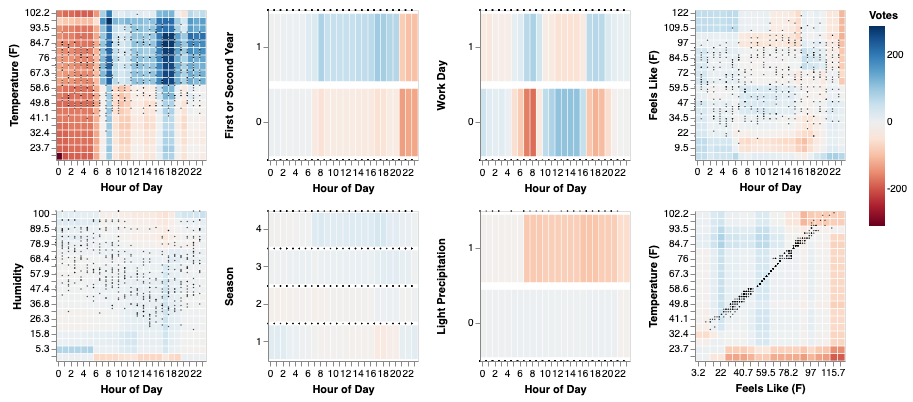

In [36]:
f2t.visualize_components()

In [83]:
single_estimator_slider = wid.IntSlider(
    value = 1,
    min = 1,
    max = 300,
    step = 1,
    continuous_update = False,
    description = "Tree #"
)
ui = wid.HBox([single_estimator_slider])
output = wid.interactive_output(
    f2t.visualize_single_estimator,
    {"estimator_num" : single_estimator_slider}
)
display(ui, output)

Output()

In [40]:
play_control = wid.Play(
    interval = 3000,
    value = 1,
    min = 1,
    max = 10,
    step = 1,
    description = "Press play"
)
play_slider = wid.IntSlider(
    value = 1,
    min = 1,
    max = 10,
    step = 1,
    continuous_update = False,
    description = "# of trees"
)
wid.jslink((play_control, 'value'), (play_slider, 'value'))
ui = wid.HBox([play_control, play_slider])
output = wid.interactive_output(
    f2t.play_components,
    {"cache_id" : play_control}
)
display(ui, output)

SEJveChjaGlsZHJlbj0oUGxheSh2YWx1ZT0xLCBkZXNjcmlwdGlvbj11J1ByZXNzIHBsYXknLCBpbnRlcnZhbD0zMDAwLCBtYXg9MTAsIG1pbj0xKSwgSW50U2xpZGVyKHZhbHVlPTEsIGNvbnTigKY=


Output()

In [41]:
#f2t.cache_visualize_datapoints()
cumulative_selector = wid.Dropdown(
    options = [('Cumulative Prediction', True), ('Contributions by Feature', False)],
    value = True,
    description = 'View',
)

num_datapoints_slider = wid.IntSlider(
    value = 50,
    min = 1,
    max = 500,
    step = 5,
    description = '# datapoints',
    continuous_update = False,
    orientation = 'horizontal',
    readout = True,
    readout_format = 'd'
)

explanation_selector = wid.Dropdown(
    options = [('95%',"minimal"), ('Full', "full")],
    value = "minimal",
    description = 'Explanation',
)

color_encoding_selector = wid.Dropdown(
    options = f2t.feature_names + ["prediction", "explanation_loss"],
    value = "prediction",
    description = 'Color By',
)

ui = wid.HBox([cumulative_selector, explanation_selector, color_encoding_selector, num_datapoints_slider])

output = wid.interactive_output(
    f2t.visualize_datapoints,
    {
        "cumulative" : cumulative_selector,
        "num_datapoints" : num_datapoints_slider,
        "explanation_type" : explanation_selector,
        "color_encoding" : color_encoding_selector
    }
)

display(ui, output)

SEJveChjaGlsZHJlbj0oRHJvcGRvd24oZGVzY3JpcHRpb249dSdWaWV3Jywgb3B0aW9ucz0oKCdDdW11bGF0aXZlIFByZWRpY3Rpb24nLCBUcnVlKSwgKCdDb250cmlidXRpb25zIGJ5IEZlYXTigKY=


Output()

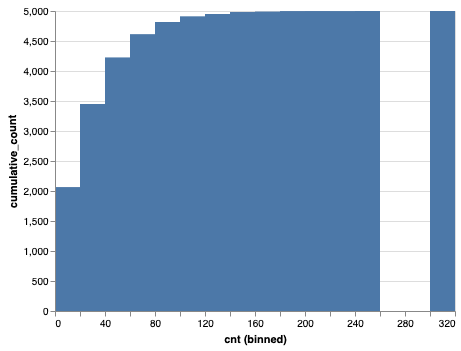

In [42]:
alt.Chart(pd.DataFrame(pd.DataFrame(np.abs(f2t.y-f2t.pred_y))).iloc[:4999,:])\
.transform_window(
    sort=[{'field': 'cnt'}],
    frame=[None, 0],
    cumulative_count='count(*)',
)\
.mark_rect().encode(
    x = alt.X("cnt", bin = alt.Bin(maxbins = 20)),
    y = "cumulative_count:Q"
)

In [43]:
bike_dataset = f2t.get_dataset("bike")
effect_additional_trees = []
train_x, test_x, train_y, test_y\
= train_test_split(bike_dataset["x"], bike_dataset["y"], test_size = 0.3)
for estimators in range(5, 300, 10):
    for depth in range(1,5):
        model = GradientBoostingRegressor(
            n_estimators = estimators, 
            max_depth = depth, 
            learning_rate = 1
        )
        model.fit(train_x, train_y)
        effect_additional_trees.append(
            {
                "number of trees" : estimators,
                "depth" : depth, 
                "train" : r2_score(model.predict(train_x), train_y),
                "test" : r2_score(model.predict(test_x), test_y)
            }
        )
effect_additional_trees_df = pd.DataFrame(effect_additional_trees)
effect_additional_trees_df = effect_additional_trees_df.melt(
    id_vars = ['number of trees', "depth"],
    var_name = 'set',
    value_name = 'r_squared'
)
effect_additional_trees_df["outcome"] = effect_additional_trees_df.apply(
    lambda x: "depth: " + str(x["depth"]) + ", set: " + x["set"],
    axis = 1
)

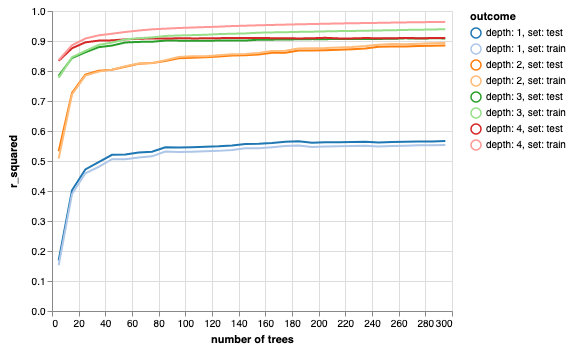

In [44]:
alt.Chart(effect_additional_trees_df).mark_line().encode(
    x = "number of trees:Q",
    y = "r_squared:Q",
    color = alt.Color("outcome", type="nominal", scale = alt.Scale(scheme = "category20"))
).interactive()

# How Do Gradient Boosted Trees Capture Patterns in a Dataset?
## A Visual Analysis of Complex Machine Learning Models with some new ideas for interpretability 

# Goal

The purpose of this notebook is to provide a visual overview of how one particular machine learning model (Gradient Boosting Trees) learns the structure in a dataset. It will look at the complete model through a few different lenses, and also watch the model build its own internal structure. The goal is to help the curious reader develop an intuition for why the model makes certain predictions, and where it is imperfect. While some of these conclusions are specific to Gradient Boosting Trees, the reader will also find some novel tools for interpreting machine learning models more broadly.

In that sense, this notebook is aimed at an audience that has some exposure to data analysis, but are not necessarily experts in machine learning. This is also an interactive notebook, so in a lot of places the reader will be able to use sliders, dropdowns, and other widgets to modify the visualization to further develop their intuition. 

The bulk of the code for this notebook is contained in hidden cells above. A fair amount of data manipulation goes into visualizing these models, but the point here is not to focus on those details. For those who are interested, the code above is collected into a library called [ForestForTheTrees](https://www.github.com/MattJBritton/ForestForTheTrees) which is under active development. Collaborators are welcome! 

This notebook was developed using Python and the Python data science stack, particularly [numpy], [pandas], and [scikit-learn]. [Altair] was used for all of the visualizations.

# Brief Introduction to Machine Learning

If you're not a data scientist, you might be most familiar with machine learning from the cool and creepy things it does that get coverage on news and social media. Things like [helping doctors diagnose patients], [making faces for non-existent people], [watching us from the skies] and [potentially sending you to prison]. While this is not a thinkpiece on the future of AI (an industry that, if it continues at the current rate, may employ so many people that it obviates its own concerns), it's fair to say that it would be easy to look at the news and glean that machine learning's primary business is to knock off another treasured "well at least only humans can do X" every day.

And certainly, anyone reviewing the latest machine learning journals would find plenty of fodder for the belief that researchers are working hard to remove humans, even developers, from the equation. How else to explain research into [automated data cleaning], [automated feature extraction], [automated data labeling], [learning from databases], etc?

As a professional data scientist, though, this is pretty far from my experience of how machine learning is applied in practice. In fact, I think that one of the best uses for machine learning is as a complement and support for human thinking. One of the forms that can take is automated insight extraction. Let's motivate this with an example.

In [ ]:
bike_data.head()

Imagine we are data analysts for a bike sharing company, and we have a dataset with each day from the past year, with the total number of bikes rented. We want to learn something that will help us predict usage for the next month, perhaps to model how to grow our fleet. The way we would usually do this is to build a machine learning model that models the relationship between facts we know (temperature that day, weather that day, day of the week, whether there was a big public festival or not) and something we know for past days, but not future ones (# of rentals). But, with our many years in the bike-sharing industry, we want to see if we can use our domain knowledge to do better. 

We certainly know many facts that are relevant to making the prediction. For example, people rent more bikes on sunny days than rainy days! But here we run into trouble. To actually make a prediction, we need to be able to calculate a precise number for a rainy Tuesday in November, and a sunny Saturday in April during the annual dogwood festival. How can we do this? We might have a sense that the average number of bikes rented on sunny days is around 3000, and the number of rainy days is about 1500. But you would be very hard-pressed to say what the exact relationship between sunny and rain is. For example, rainy days tend to be colder. Maybe it's the cold that drives down ridership, and if two days have identical temperatures but one is rainy and the other sunny, ridership will be about the same. Not to mention rain is more common during certain parts of the year, and rain probably affects ridership differently on weekdays vs. weekends, and you can see we have a big mess. These issues, which are referred to as *collinearity* and *interaction effects* are not our main concern here, but they are the bane of social scientists and generally bedevil data analysis.

The point is that our domain knowledge may be deep and complex, but it's no good for making specific predictions. Research has shown this [again] and [again] and [again].

In [ ]:
#linear regression

However, one of the simplest machine learning models, linear regression, can calculate this in a second. We get a coefficient that tells us that when it rains, ridership drops by X. Or that for every degree increase of temperature, ridership increases by 50. These conclusions are overly simplistic, as we'll see below, but our model can give us this number and tell us that it is the best possible one (given the limitations of the dataset we give it, and the expressiveness of the model). We can also use a much more powerful and complex model, such as a Support Vector Machine, and see what it found. The SVM doesn't give us a nice figure, but we can extract something better with a chart called a [Partial Dependence Plot] (PDP). Essentially, a PDP calculates how a prediction changes as we move only one value up and down from the minimum to the maximum. You can see the PDP plot for temperature's effect on ridership below, from 19F-102F.

In [ ]:
#SVM and 1d PDP

We can now see that the reality was far more complex than our linear regression indicated. Temperature has a *non-linear* effect on ridership, in that there's not a steady, uniform increase. Rather, at some points in the range, rising temperature means more riders, and in other places, it means less. And ridership rises and falls at different rates in the range. We can no longer succinctly express the effect of temperature in a number, but we now have this curve, which is the most parsimonious (without summarizing and losing information) representation of the actual behavior. 

It should be clear that domain expertise won't get us this partial dependence curve. We wouldn't have a lot of luck drawing it out. This is something that computers are going to be able to extract far more efficiently than humans, furious optimizers that they are. However, we need to consider another aspect as well.

# When the Machine is Wrong

In [ ]:
#story about asthma

At this point, we have a better sense of the relative merits of human and machine analysis. Broadly, machines can find the thresholds, decision boundaries, line slopes, and other "facts" that are optimal for our dataset. They can assemble these into specific predictions. But, because humans understand the meaning of data in its real-world context, and have a rich tapestry of experience, we have a good sense of generally what kind of facts we SHOULD find. We can be surprised, and can be wrong, but know to question things that seem suspicious. Each complements the other.

# Machine Learning For Insight Extraction

So at this point, the answer might seem obvious - computers should build data models, people should inspect, guide, and review them, and we'll end up with high quality data analysis. We can term this "automated insight extraction" - analysts build models not because they should be used for automated predictions (at least right off the bat), but because they find facts far more efficiently than people, yet have no idea what they mean. 

The problem is that computers broadly and models specifically are terrible at telling us what they know. Models do not store a list of neat facts that we can just read. Instead, their internals are just data structures, consisting of matrices that represent more abstract (but frequently still opaque) concepts such as decision trees, artificial neurons, weights and bias terms, etc. Techniques like the partial dependence plots above have to be applied as a secondary process to generate something human-readable out of the model, and have known [weaknesses], in which they fail to extract everything the model "knows". 

The purpose of this notebook is to pick one complex model type (Gradient Boosting Trees), make some simplifying restrictions, and then present some interactive visual techniques to extract as much of what the model "knows" as possible into a form that humans (at least, those with a minimum of visual literacy) can understand. And, we'll also look at a method for proving how much of that potential insight we actually got out, so that we can have confidence that the model won't do things we won't understand once it is in production. That'll lead to some neat things where we can make explicit tradeoffs between complexity and fidelity to the underlying model. But first, let's discuss exactly Gradient Boosting Trees are. 

# Gradient Boosting Trees